In [1]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 4.9 MB/s 


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchmetrics
from torchvision import models
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset, SubsetRandomSampler
import matplotlib.pyplot as plt

import numpy as np
import seaborn as snsn

In [4]:
Device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(Device)

cuda


In [5]:
num_epoch = 40
batch_size = 128
lR = 0.001
calsses = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [6]:
train_dataset = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = torch.tensor)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [7]:
mean = ((train_dataset.data).mean((0,1,2)))/255
std = ((train_dataset.data).std((0,1,2)))/255

transform = transforms.Compose([
                             
        transforms.Resize(size = (32, 32)),
        transforms.ToTensor(),
        transforms.Normalize(mean,std)
])

In [8]:
dataset = torchvision.datasets.CIFAR10(
    root = './data', train = True, download = True, transform = transform
)

test_dataset =  torchvision.datasets.CIFAR10(
    root = './data', train = False, download = True, transform = transform
)

Files already downloaded and verified
Files already downloaded and verified


In [9]:
class dataset_per_class(Dataset):
    def __init__(self,dataset, c):
        self.dataset = dataset
        self.i = np.where(np.array(self.dataset.targets) == c)[0]
    def __len__(self):
        return len(self.i)
    def __getitem__(self,idx):
        return self.dataset[self.i[idx]]

In [10]:
train_dataset, val_dataset = torch.utils.data.random_split(dataset,[45000,5000])

In [11]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size = batch_size)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = batch_size)

In [12]:
n_total_step = len(train_loader)
print(n_total_step)

352


In [13]:
samples = torch.Tensor(test_dataset.data)
samples = samples.flatten(1)
samples.shape

torch.Size([10000, 3072])

In [14]:
targets = torch.LongTensor(test_dataset.targets)
targets = targets.view(targets.size(0), 1).expand(-1, samples.size(1))
targets.shape

torch.Size([10000, 3072])

In [15]:
unique_labels, labels_count = targets.unique(dim=0, return_counts=True)
print("Class  ", "   Count")
for (i, j) in zip(unique_labels, labels_count):
  print(i[0], j)


Class      Count
tensor(0) tensor(1000)
tensor(1) tensor(1000)
tensor(2) tensor(1000)
tensor(3) tensor(1000)
tensor(4) tensor(1000)
tensor(5) tensor(1000)
tensor(6) tensor(1000)
tensor(7) tensor(1000)
tensor(8) tensor(1000)
tensor(9) tensor(1000)


In [16]:
res = torch.zeros_like(unique_labels, dtype=torch.float).scatter_add_(0, targets, samples)
res = res / labels_count.float().unsqueeze(1)

In [19]:
class VGG(nn.Module):
    def __init__(self ):
                super().__init__()
                self.conv1 = nn.Conv2d(3,64, (3, 3), padding=(1, 1))
                self.bn1 = nn.BatchNorm2d(64)
                self.d1 = nn.Dropout(0.3)
                self.conv2 = nn.Conv2d(64,64, (3, 3), padding=(1, 1))
                self.bn2 = nn.BatchNorm2d(64)
                self.mp1 = nn.MaxPool2d((2, 2))
                self.conv3 = nn.Conv2d(64,128, (3, 3), padding=(1, 1))
                self.bn3 = nn.BatchNorm2d(128)
                self.d2 = nn.Dropout2d(0.4)
                self.conv4 = nn.Conv2d(128,128, (3, 3), padding=(1, 1))
                self.bn4 = nn.BatchNorm2d(128)
                self.mp2 = nn.MaxPool2d((2, 2))
                self.conv5 = nn.Conv2d(128,256, (3, 3), padding=(1, 1))
                self.bn5 = nn.BatchNorm2d(256)
                self.d3 = nn.Dropout2d(0.4)
                self.conv6 = nn.Conv2d(256,256, (3, 3), padding=(1, 1))
                self.bn6 = nn.BatchNorm2d(256)
                self.d4 = nn.Dropout(0.4)
                self.conv7 = nn.Conv2d(256,256, (3, 3), padding=(1, 1))
                self.bn7 = nn.BatchNorm2d(256)
                self.mp3 = nn.MaxPool2d((2, 2))
                self.conv8 = nn.Conv2d(256,512, (3, 3), padding=(1, 1))
                self.bn8 = nn.BatchNorm2d(512)
                self.d5 = nn.Dropout2d(0.4)
                self.conv9 = nn.Conv2d(512,512, (3, 3), padding=(1, 1))
                self.bn9 = nn.BatchNorm2d(512)
                self.d6 = nn.Dropout2d(0.4)

                self.conv10 = nn.Conv2d(512,512, (3, 3), padding=(1, 1))
                self.bn10 = nn.BatchNorm2d(512)
                self.mp4 = nn.MaxPool2d((2, 2))

                self.conv11 = nn.Conv2d(512,512, (3, 3), padding=(1, 1))
                self.bn11 = nn.BatchNorm2d(512)
                self.d7 = nn.Dropout2d(0.4)

                self.conv12 = nn.Conv2d(512,512, (3, 3), padding=(1, 1))
                self.bn12 = nn.BatchNorm2d(512)
                self.d8 = nn.Dropout2d(0.4)

                self.conv13 = nn.Conv2d(512,512, (3, 3), padding=(1, 1))
                self.bn13 = nn.BatchNorm2d(512)
                self.mp5 = nn.MaxPool2d((2, 2))
                self.d9 = nn.Dropout2d(0.5)

                self.flatten = nn.Flatten()

                self.fc1 = nn.Linear(512,512)
                self.bn1d = nn.BatchNorm1d(num_features=512)
                self.d10 = nn.Dropout(0.5)
                self.fc2 = nn.Linear(512,10)
  

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = self.d1(x)
        x = F.relu(self.conv2(x))
        x = self.bn2(x)
        x = self.mp1(x)

        x = F.relu(self.conv3(x))
        x = self.bn3(x)
        x = self.d2(x)

        x = F.relu(self.conv4(x))
        x = self.bn4(x)
        x = self.mp2(x)

        x = F.relu(self.conv5(x))
        x = self.bn5(x)
        x = self.d3(x)

        x = F.relu(self.conv6(x))
        x = self.bn6(x)
        x = self.d4(x)

        x = F.relu(self.conv7(x))
        x = self.bn7(x)
        x = self.mp3(x)

        x = F.relu(self.conv8(x))
        x = self.bn8(x)
        x = self.d5(x)

        x = F.relu(self.conv9(x))
        x = self.bn9(x)
        x = self.d6(x)

        x = F.relu(self.conv10(x))
        x = self.bn10(x)
        x = self.mp4(x)

        x = F.relu(self.conv11(x))
        x = self.bn11(x)
        x = self.d7(x)

        x = F.relu(self.conv12(x))
        x = self.bn12(x)
        x = self.d8(x)

        x = F.relu(self.conv13(x))
        x = self.bn13(x)
        x = self.mp5(x)
        x = self.d9(x)

        x = self.flatten(x)

        x = F.relu(self.fc1(x))
        x = self.bn1d(x)
        x = self.d10(x)
        x = self.fc2(x)

        return x
        

In [21]:
model2 = VGG()
model2.to(Device);

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model2.parameters(), lr=0.001, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9, verbose=True)
epochs = 40
accuracy = torchmetrics.Accuracy().to(Device)

Adjusting learning rate of group 0 to 1.0000e-03.


In [23]:
for name, layer in model2._modules.items():
    print(name)

conv1
bn1
d1
conv2
bn2
mp1
conv3
bn3
d2
conv4
bn4
mp2
conv5
bn5
d3
conv6
bn6
d4
conv7
bn7
mp3
conv8
bn8
d5
conv9
bn9
d6
conv10
bn10
mp4
conv11
bn11
d7
conv12
bn12
d8
conv13
bn13
mp5
d9
flatten
fc1
bn1d
d10
fc2


In [24]:
loss_train = []
loss_val = []
acc_train = []
acc_val = []


for epoch in range(epochs):

    model2.train()

    total_loss = 0
    total_acc = 0

    for inputs, labels in tqdm(train_loader,leave=False):

        inputs, labels = inputs.to(Device), labels.to(Device)
        outputs = model2(inputs)
        
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        with torch.no_grad():
            total_acc += accuracy(torch.argmax(outputs,1), labels).item()

    loss_train.append(total_loss/len(train_loader))
    acc_train.append(total_acc/len(train_loader))

    model2.eval()

    total_loss = 0
    total_acc = 0

    with torch.no_grad():

        for inputs, labels in tqdm(val_loader,leave=False):

            inputs, labels = inputs.to(Device),labels.to(Device)
            outputs = model2(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            total_acc +=accuracy(torch.argmax(outputs,1),labels).item()


        loss_val.append(total_loss/len(val_loader))
        acc_val.append(total_acc/len(val_loader))

        print(f" epoch{epoch+1}: train_loss-> {loss_train[-1]}, val_loss-> {loss_val[-1]}, train accuracy -> {acc_train[-1]}, val_accuracy -> {acc_val[-1]}")
        scheduler.step()

 epoch1: train_loss-> 1.8908481442115523, val_loss-> 1.5525627046823502, train accuracy -> 0.2738419349559329, val_accuracy -> 0.3935546875
Adjusting learning rate of group 0 to 9.0000e-04.


 epoch2: train_loss-> 1.4578396129337223, val_loss-> 1.2437538743019103, train accuracy -> 0.4526761758395217, val_accuracy -> 0.5375
Adjusting learning rate of group 0 to 8.1000e-04.


 epoch3: train_loss-> 1.1771699545735663, val_loss-> 0.9697987049818039, train accuracy -> 0.5784431226890195, val_accuracy -> 0.648046875
Adjusting learning rate of group 0 to 7.2900e-04.


 epoch4: train_loss-> 0.9925504577430811, val_loss-> 0.8507806196808815, train accuracy -> 0.6513523911549286, val_accuracy -> 0.7138671875
Adjusting learning rate of group 0 to 6.5610e-04.


 epoch5: train_loss-> 0.8722207290543751, val_loss-> 0.73225162550807, train accuracy -> 0.6988389756191861, val_accuracy -> 0.74375
Adjusting learning rate of group 0 to 5.9049e-04.


 epoch6: train_loss-> 0.7793374571271918, val_loss-> 0.6705736860632896, train accuracy -> 0.7370975378223441, val_accuracy -> 0.7712890625
Adjusting learning rate of group 0 to 5.3144e-04.


 epoch7: train_loss-> 0.7014209304682233, val_loss-> 0.6041927568614482, train accuracy -> 0.7647322837940671, val_accuracy -> 0.7916015625
Adjusting learning rate of group 0 to 4.7830e-04.


 epoch8: train_loss-> 0.6365856369957328, val_loss-> 0.5659593403339386, train accuracy -> 0.787370778112249, val_accuracy -> 0.8060546875
Adjusting learning rate of group 0 to 4.3047e-04.


 epoch9: train_loss-> 0.5809605850584127, val_loss-> 0.5597156032919883, train accuracy -> 0.805609809065407, val_accuracy -> 0.8162109375
Adjusting learning rate of group 0 to 3.8742e-04.


 epoch10: train_loss-> 0.5242278926413168, val_loss-> 0.5421977937221527, train accuracy -> 0.8247193616222251, val_accuracy -> 0.829296875
Adjusting learning rate of group 0 to 3.4868e-04.


 epoch11: train_loss-> 0.48771543758498, val_loss-> 0.5191027946770191, train accuracy -> 0.8369165286421776, val_accuracy -> 0.8337890625
Adjusting learning rate of group 0 to 3.1381e-04.


 epoch12: train_loss-> 0.4470627058551393, val_loss-> 0.5097386904060841, train accuracy -> 0.8511753275313161, val_accuracy -> 0.828125
Adjusting learning rate of group 0 to 2.8243e-04.


 epoch13: train_loss-> 0.4114487396807156, val_loss-> 0.49453614503145216, train accuracy -> 0.8636388297785412, val_accuracy -> 0.8427734375
Adjusting learning rate of group 0 to 2.5419e-04.


 epoch14: train_loss-> 0.37773764827712014, val_loss-> 0.4826493844389915, train accuracy -> 0.8733600655739958, val_accuracy -> 0.8478515625
Adjusting learning rate of group 0 to 2.2877e-04.


 epoch15: train_loss-> 0.34758585725318303, val_loss-> 0.47663575429469346, train accuracy -> 0.8837594696405259, val_accuracy -> 0.8421875
Adjusting learning rate of group 0 to 2.0589e-04.


 epoch16: train_loss-> 0.31879751913418825, val_loss-> 0.4665155531838536, train accuracy -> 0.8928247317671776, val_accuracy -> 0.85546875
Adjusting learning rate of group 0 to 1.8530e-04.


 epoch17: train_loss-> 0.2900318909563463, val_loss-> 0.4763064481317997, train accuracy -> 0.9019072562117468, val_accuracy -> 0.855078125
Adjusting learning rate of group 0 to 1.6677e-04.


 epoch18: train_loss-> 0.2703754250171848, val_loss-> 0.4813509456813335, train accuracy -> 0.9093005247414112, val_accuracy -> 0.8548828125
Adjusting learning rate of group 0 to 1.5009e-04.


 epoch19: train_loss-> 0.24850465679033237, val_loss-> 0.4657307015731931, train accuracy -> 0.9163904670964588, val_accuracy -> 0.8623046875
Adjusting learning rate of group 0 to 1.3509e-04.


 epoch20: train_loss-> 0.2320554890796881, val_loss-> 0.5005687743425369, train accuracy -> 0.9241043244573203, val_accuracy -> 0.853125
Adjusting learning rate of group 0 to 1.2158e-04.


 epoch21: train_loss-> 0.21099215157499368, val_loss-> 0.4809793774038553, train accuracy -> 0.9293866397982294, val_accuracy -> 0.858203125
Adjusting learning rate of group 0 to 1.0942e-04.


 epoch22: train_loss-> 0.19869565447284418, val_loss-> 0.4781437233090401, train accuracy -> 0.9332706951959566, val_accuracy -> 0.86796875
Adjusting learning rate of group 0 to 9.8477e-05.


 epoch23: train_loss-> 0.18910707190463488, val_loss-> 0.5009045645594596, train accuracy -> 0.9363483468239958, val_accuracy -> 0.8576171875
Adjusting learning rate of group 0 to 8.8629e-05.


 epoch24: train_loss-> 0.17292128635612738, val_loss-> 0.4894313745200634, train accuracy -> 0.942210187796842, val_accuracy -> 0.867578125
Adjusting learning rate of group 0 to 7.9766e-05.


 epoch25: train_loss-> 0.1644453585507687, val_loss-> 0.48755358485504985, train accuracy -> 0.9448562775823203, val_accuracy -> 0.8708984375
Adjusting learning rate of group 0 to 7.1790e-05.


 epoch26: train_loss-> 0.15558501162608576, val_loss-> 0.498746919259429, train accuracy -> 0.9476799241859805, val_accuracy -> 0.8671875
Adjusting learning rate of group 0 to 6.4611e-05.


 epoch27: train_loss-> 0.1429862252817574, val_loss-> 0.49234073790721594, train accuracy -> 0.9520645912059329, val_accuracy -> 0.8712890625
Adjusting learning rate of group 0 to 5.8150e-05.


 epoch28: train_loss-> 0.1395437389358201, val_loss-> 0.5050193408504129, train accuracy -> 0.9526021937755021, val_accuracy -> 0.8658203125
Adjusting learning rate of group 0 to 5.2335e-05.


 epoch29: train_loss-> 0.13690961846573788, val_loss-> 0.49422453916631637, train accuracy -> 0.9539018110795454, val_accuracy -> 0.874609375
Adjusting learning rate of group 0 to 4.7101e-05.


 epoch30: train_loss-> 0.12128738302271813, val_loss-> 0.5029254441149533, train accuracy -> 0.9586514559659091, val_accuracy -> 0.87265625
Adjusting learning rate of group 0 to 4.2391e-05.


 epoch31: train_loss-> 0.12390380157475275, val_loss-> 0.4913000038941391, train accuracy -> 0.9579288983209566, val_accuracy -> 0.8732421875
Adjusting learning rate of group 0 to 3.8152e-05.


 epoch32: train_loss-> 0.1164165853723799, val_loss-> 0.5032988503575325, train accuracy -> 0.9599042179232294, val_accuracy -> 0.8720703125
Adjusting learning rate of group 0 to 3.4337e-05.


 epoch33: train_loss-> 0.11258944937303154, val_loss-> 0.5054333743173629, train accuracy -> 0.9625009863891385, val_accuracy -> 0.869921875
Adjusting learning rate of group 0 to 3.0903e-05.


 epoch34: train_loss-> 0.10993187890959565, val_loss-> 0.507939777080901, train accuracy -> 0.9636279789900238, val_accuracy -> 0.8724609375
Adjusting learning rate of group 0 to 2.7813e-05.


 epoch35: train_loss-> 0.10511887878899208, val_loss-> 0.5063522885437124, train accuracy -> 0.9650656960227273, val_accuracy -> 0.8736328125
Adjusting learning rate of group 0 to 2.5032e-05.


 epoch36: train_loss-> 0.10666592583716424, val_loss-> 0.5078499059542082, train accuracy -> 0.9642223011363636, val_accuracy -> 0.874609375
Adjusting learning rate of group 0 to 2.2528e-05.


 epoch37: train_loss-> 0.0996647649762136, val_loss-> 0.5114992635091766, train accuracy -> 0.9664294309914112, val_accuracy -> 0.873046875
Adjusting learning rate of group 0 to 2.0276e-05.


 epoch38: train_loss-> 0.0980142782209441, val_loss-> 0.5097721598576754, train accuracy -> 0.966535471887751, val_accuracy -> 0.8755859375
Adjusting learning rate of group 0 to 1.8248e-05.


 epoch39: train_loss-> 0.09424678910396654, val_loss-> 0.51968972030445, train accuracy -> 0.9683948863636364, val_accuracy -> 0.870703125
Adjusting learning rate of group 0 to 1.6423e-05.


 epoch40: train_loss-> 0.09756280458796854, val_loss-> 0.5125351646740455, train accuracy -> 0.9672185724431818, val_accuracy -> 0.873046875
Adjusting learning rate of group 0 to 1.4781e-05.


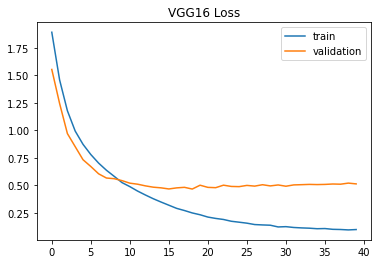

In [55]:
plt.plot(loss_train)
plt.plot(loss_val)
plt.legend(['train','validation'])
plt.title("VGG16 Loss");

Text(0.5, 1.0, 'VGG16 Accuracy')

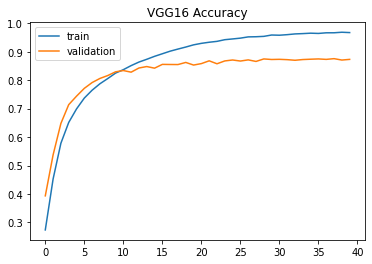

In [56]:
plt.plot(acc_train)
plt.plot(acc_val)
plt.legend(['train', 'validation'])
plt.title("VGG16 Accuracy")

In [27]:
layers_name  = [name  for name, layer in model2._modules.items()]
layers_layer = [layer for name, layer in model2._modules.items()]

In [28]:
def get_layer_output(x):
  activation = {}

  def get_activation(name):
    def hook(model, input, output):
      activation[name] = output.detach().flatten(1)
    return hook

  for i in range(len(layers_name)):
    #model = MyModel()
    layers_layer[i].register_forward_hook(get_activation(layers_name[i]))
    #x = torch.rand(1,3, 32, 32).to(Device)
    output = model2(x)
    #print(activation[layers_name[i]].flatten(1).shape)
  return activation

In [29]:
x = torch.rand(3,3, 32, 32).to(Device)
a = get_layer_output(x)

In [30]:
test_loader = []
test_indices = [i for i in range(1000)]
for i in range(10):
  
  np.random.shuffle(test_indices)
  index = int(np.floor(0.1 * 1000)) 
  idx= test_indices[:index]
  sampler = SubsetRandomSampler(idx)  
  d = dataset_per_class(test_dataset , i)#dataset / class
  test_loader.append(torch.utils.data.DataLoader(d, batch_size = batch_size,sampler = sampler))

In [31]:
sum = 0 
for inputs, labels in test_loader[0]:
  inputs = inputs.to(Device)
  sum += get_layer_output(inputs)['bn1'].sum(0)
(sum/100).shape

torch.Size([65536])

In [32]:
dict_mean = {}
for c in range(10):
  dict_mean[c]={}
  for i in layers_name:
    dict_mean[c][i] = 0

for c in range(10):#for each class
  print(c)
  for inputs, labels in test_loader[c]:
    inputs, labels = inputs.to(Device), labels.to(Device)
    #get_layer_output(inputs)
    for name in layers_name:
      dict_mean[c][name]+=get_layer_output(inputs)[name].sum(0)


0
1
2
3
4
5
6
7
8
9


In [34]:
for c in range(10):
  for i,(input, label) in enumerate(test_loader[c]):
    pass

In [ ]:
for name, idx in enumerate(layers_name):
  print(name)

In [42]:
total_SI = [0]*len(layers_name)
for c in range(10):
    for i,(inputs, labels) in enumerate(test_loader[c]):
      inputs = inputs.to(Device)
      labels = labels.to(Device)

      for idx, name in enumerate(layers_name):
          SI_count = 0
          ss = get_layer_output(inputs)[name]

          norm = torch.tensor(()).to(Device)
          for i in range(10):
            temp = torch.norm((ss - (dict_mean[i][name]/100)),dim = -1).unsqueeze(0)

            norm = torch.cat((norm, temp),dim =0)

          SI_count+=(torch.argmin(norm,dim = 0) == labels).sum()

          total_SI[idx]+=SI_count


In [ ]:
SI_plot = [si.cpu()/1000 for si in total_SI]

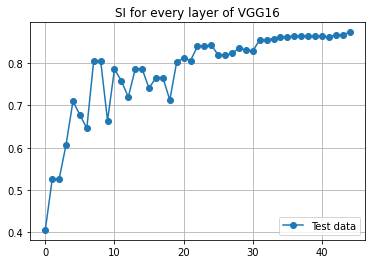

In [72]:
plt.plot(SI_plot , '-o')
plt.grid("on")
plt.legend(['Test data'], loc = 'lower right')
plt.title('SI for every layer of VGG16');